
--- Hypothesis Testing Results ---
B_min      B          B/B_min    Var(Est)     Threshold    Decision   Correct   
0.20       0.00       0.00       0.00000      0.00100      H0         True      
0.20       0.10       0.50       0.00063      0.00100      H0         False     
0.20       0.20       1.00       0.00248      0.00100      H1         True      
0.20       0.30       1.50       0.00524      0.00100      H1         True      
0.20       0.40       2.00       0.00836      0.00100      H1         True      
0.20       0.50       2.50       0.01119      0.00100      H1         True      
0.20       0.60       3.00       0.01305      0.00100      H1         True      
0.40       0.00       0.00       0.00000      0.00100      H0         True      
0.40       0.20       0.50       0.00248      0.00100      H1         False     
0.40       0.40       1.00       0.00836      0.00100      H1         True      
0.40       0.60       1.50       0.01305      0.00100      H1         Tru

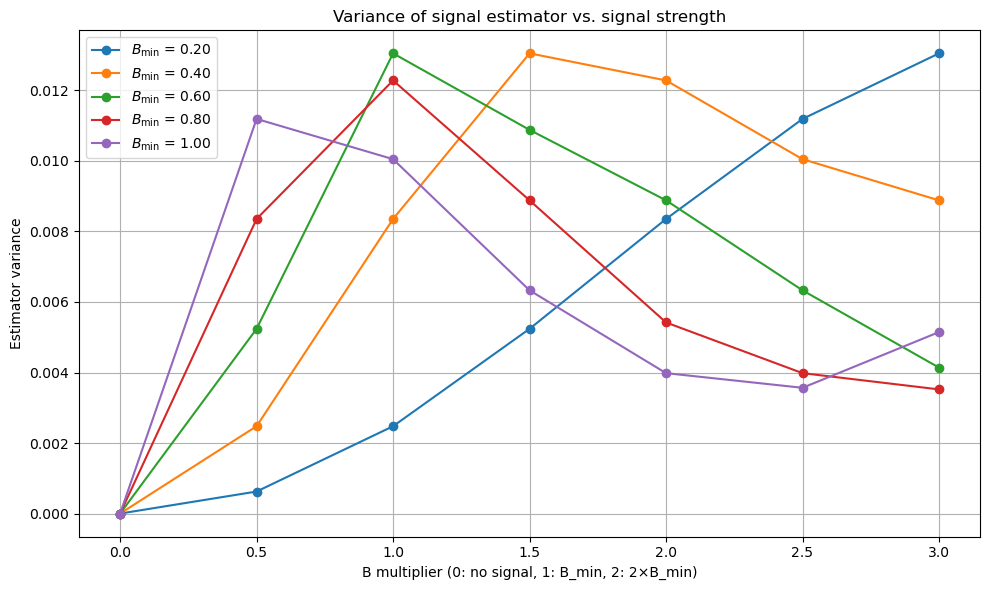

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# --- Simulation Parameters ---
T = 5.0
steps = 1000
times = np.linspace(0, T, steps)
g = 1.0

# Sweep parameters
delta_omega = [0.2, 0.4, 0.6, 0.8, 1.0]     # B_min values
omegas = np.linspace(0, 1, 15)             # signal frequencies
B_factors = [0, 0.5, 1, 1.5, 2, 2.5, 3]     # multiples of B_min

# Qubit Operators
sx, sy, sz = sigmax(), sigmay(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

# Store estimation results
results = {}

# Estimate signal strength using both ⟨Z⟩ and ⟨X⟩ expectation values
def estimate_signal_strength(z_vals, x_vals, tvals):
    # Combine into "contrast" estimator (heuristic)
    contrast = np.std(z_vals) + np.std(x_vals)
    return contrast

# Simulation
for B_min in delta_omega:
    results[B_min] = {}
    for B_mult in B_factors:
        B = B_mult * B_min
        B_estimates = []

        for omega in omegas:
            # Define time-dependent Hamiltonian: H = gX + B cos(ωt)Z
            H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
            result = mesolve(H, psi0, times, [], [sz, sx])
            z_vals = result.expect[0]
            x_vals = result.expect[1]

            est = estimate_signal_strength(z_vals, x_vals, times)
            B_estimates.append(est)

        avg_est = np.mean(B_estimates)
        var_est = np.var(B_estimates)
        results[B_min][B] = {"mean": avg_est, "var": var_est}

# --- Hypothesis Testing ---
print("\n--- Hypothesis Testing Results ---")
print("{:<10} {:<10} {:<10} {:<12} {:<12} {:<10} {:<10}".format(
    "B_min", "B", "B/B_min", "Var(Est)", "Threshold", "Decision", "Correct"
))

for B_min in delta_omega:
    baseline_var = results[B_min][0.0]["var"]
    # Apply fixed gap thresholding (for distinguishability)
    threshold = baseline_var + 0.001  # avoid numerical zero issue

    for B_mult in B_factors:
        B = B_mult * B_min
        var = results[B_min][B]["var"]
        decision = "H1" if var > threshold else "H0"
        correct = ((B_mult == 0 and decision == "H0") or
                   (B_mult >= 1.0 and decision == "H1"))

        print("{:<10.2f} {:<10.2f} {:<10.2f} {:<12.5f} {:<12.5f} {:<10} {:<10}".format(
            B_min, B, B_mult, var, threshold, decision, str(correct)
        ))

# --- Plotting: Estimator Variance ---
plt.figure(figsize=(10, 6))
for B_min in delta_omega:
    vars_ = [results[B_min][B_mult * B_min]["var"] for B_mult in B_factors]
    plt.plot(B_factors, vars_, marker='o', label=f'$B_{{\\min}}$ = {B_min:.2f}')
plt.xlabel("B multiplier (0: no signal, 1: B_min, 2: 2×B_min)")
plt.ylabel("Estimator variance")
plt.title("Variance of signal estimator vs. signal strength")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
